In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../../..')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [3]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

/opt/miniconda3/envs/replay_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [5]:
interactions = pd.read_parquet("/RePlay-Accelerated/replay_benchmarks/data/beauty/interactions.parquet")

In [6]:
interactions

,user_id,item_id,rating,timestamp
0,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00V6R3R3S,5.0,1452647102000
2,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00JIIUJ5Q,4.0,1454675735000
4,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00YAZBWZI,5.0,1458095420000
5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B00D5ZL83U,5.0,1384912377000
6,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0C43HKQMM,5.0,1384912580000
...,...,...,...,...
6624436,AHK7KOTTU4XURTJ76PW5KDF7S7MQ,B000PYAC86,5.0,1691973175744
6624437,AHK7KOTTU4XURTJ76PW5KDF7S7MQ,B07SPY1GJG,5.0,1691973217288
6624438,AHK7KOTTU4XURTJ76PW5KDF7S7MQ,B0B9HV7S8B,5.0,1691973274033
6624439,AHK7KOTTU4XURTJ76PW5KDF7S7MQ,B07L8QNGZF,5.0,1691973478471


In [7]:
interactions['rating'].describe()

count    5.216935e+06
mean     4.832777e+00
std      3.731748e-01
min      4.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 725156
Number of unique items: 207369


In [9]:
pd.to_datetime(interactions['timestamp'], unit='ms').describe()

count                          5216935
mean     2019-06-13 07:47:46.943231488
min                2000-12-20 01:09:42
25%         2017-04-19 17:50:20.500000
50%      2019-12-26 04:00:26.832999936
75%      2021-10-03 21:10:52.033499904
max         2023-09-12 15:08:21.839000
Name: timestamp, dtype: object

In [10]:
pd.to_datetime(interactions['timestamp'], unit='ms')

0         2016-01-13 01:05:02.000
2         2016-02-05 12:35:35.000
4         2016-03-16 02:30:20.000
5         2013-11-20 01:52:57.000
6         2013-11-20 01:56:20.000
                    ...          
6624436   2023-08-14 00:32:55.744
6624437   2023-08-14 00:33:37.288
6624438   2023-08-14 00:34:34.033
6624439   2023-08-14 00:37:58.471
6624440   2023-08-14 00:38:26.683
Name: timestamp, Length: 5216935, dtype: datetime64[ns]

In [11]:
interactions.head()

,user_id,item_id,rating,timestamp
0,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00V6R3R3S,5.0,1452647102000
2,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00JIIUJ5Q,4.0,1454675735000
4,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00YAZBWZI,5.0,1458095420000
5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B00D5ZL83U,5.0,1384912377000
6,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0C43HKQMM,5.0,1384912580000


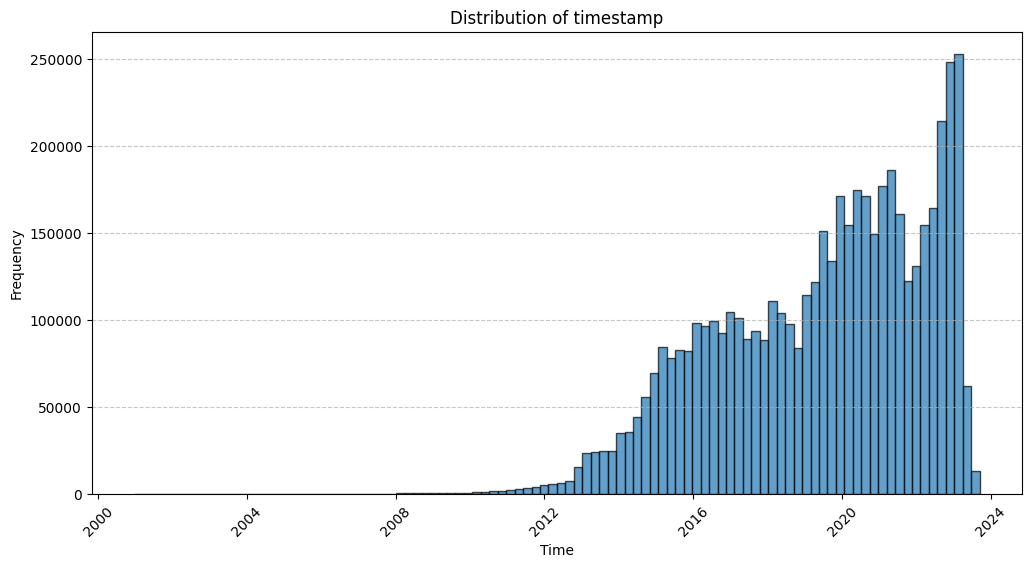

In [12]:
def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 'ms', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [13]:
# Фильтруем данные по минимальному рейтингу
interactions = interactions[
                interactions['rating']
                > 3
            ]

In [14]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 3


In [38]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='ms'))
print(pd.to_datetime(interactions.timestamp.max(), unit='ms'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.3f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.3f}")

(5027587, 4)
2000-12-20 01:09:42
2023-09-12 15:08:21.839000
Interaction Density: 0.004%
Mean Sequence Length: 7.460


In [16]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 673952
Number of unique items: 176450


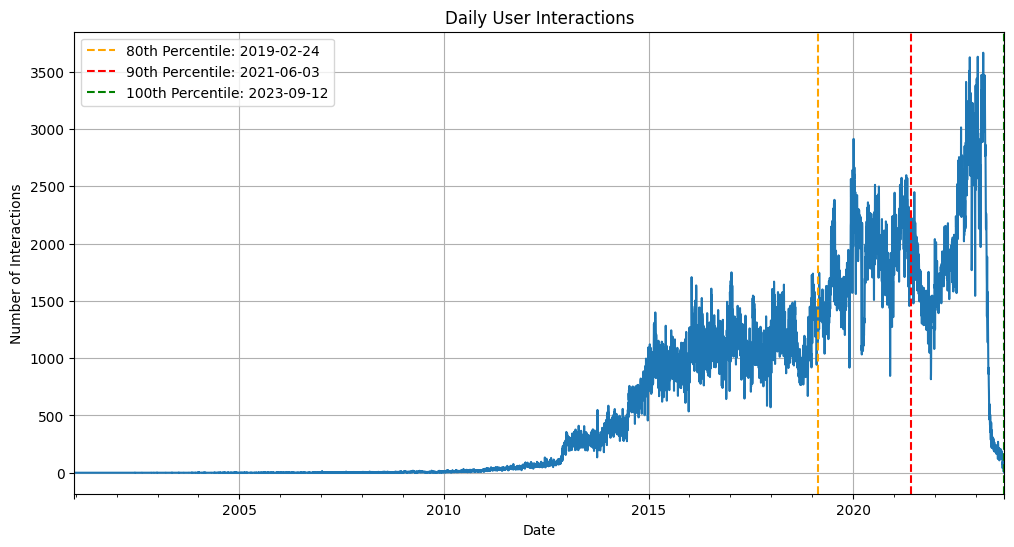

In [17]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='ms')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    135896.000000
mean          1.940035
std           2.499592
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         174.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    96763.000000
mean         1.831092
std          1.911849
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         68.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    135896.000000
mean          1.940035
std           2.499592
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         174.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    96763.000000
mean         1.831092
std          1.911849
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         68.000000
Name: item

In [19]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [20]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [21]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 129477
Number of unique query_ids: 135896


count    135896.000000
mean          6.459682
std          16.869620
min           1.000000
25%           3.000000
50%           4.000000
75%           7.000000
max        2058.000000
Name: item_id_seq, dtype: float64

In [22]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
print(sequence_lengths.describe())
print(splits['validation_gt'].shape)

Number of unique item_ids: 55264
Number of unique query_ids: 135896
count    135896.000000
mean          1.940035
std           2.499592
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         174.000000
Name: item_id_seq, dtype: float64
(263643, 4)


In [23]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 120903
Number of unique query_ids: 96763


count    96763.000000
mean         7.189091
std         19.679138
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max       2063.000000
Name: item_id_seq, dtype: float64

In [24]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
print(splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe())
print(splits['test_gt'].shape)

Number of unique item_ids: 43608
Number of unique query_ids: 96763
count    96763.000000
mean         1.831092
std          1.911849
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         68.000000
Name: item_id, dtype: float64
(177182, 4)


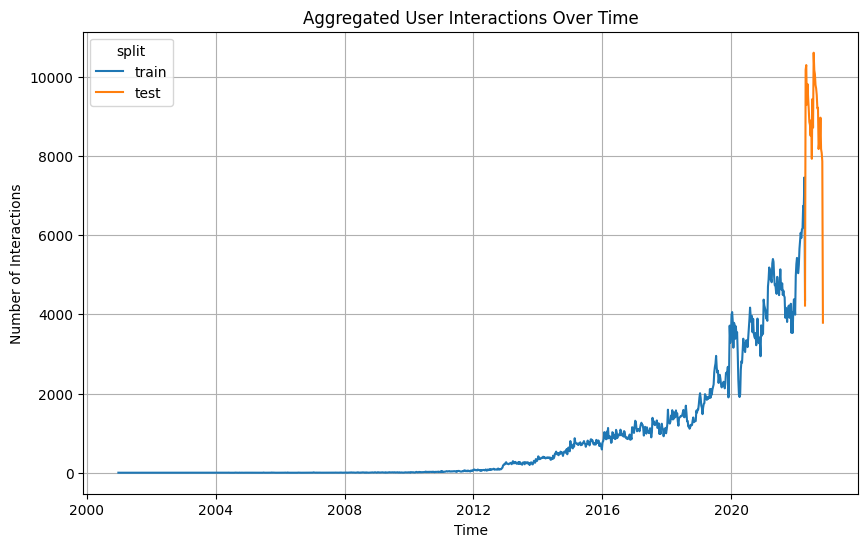

In [25]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

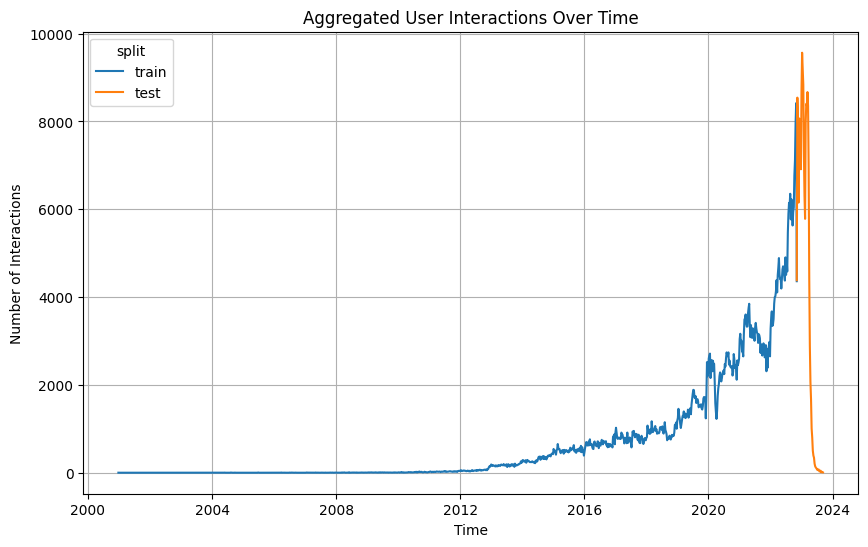

In [26]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

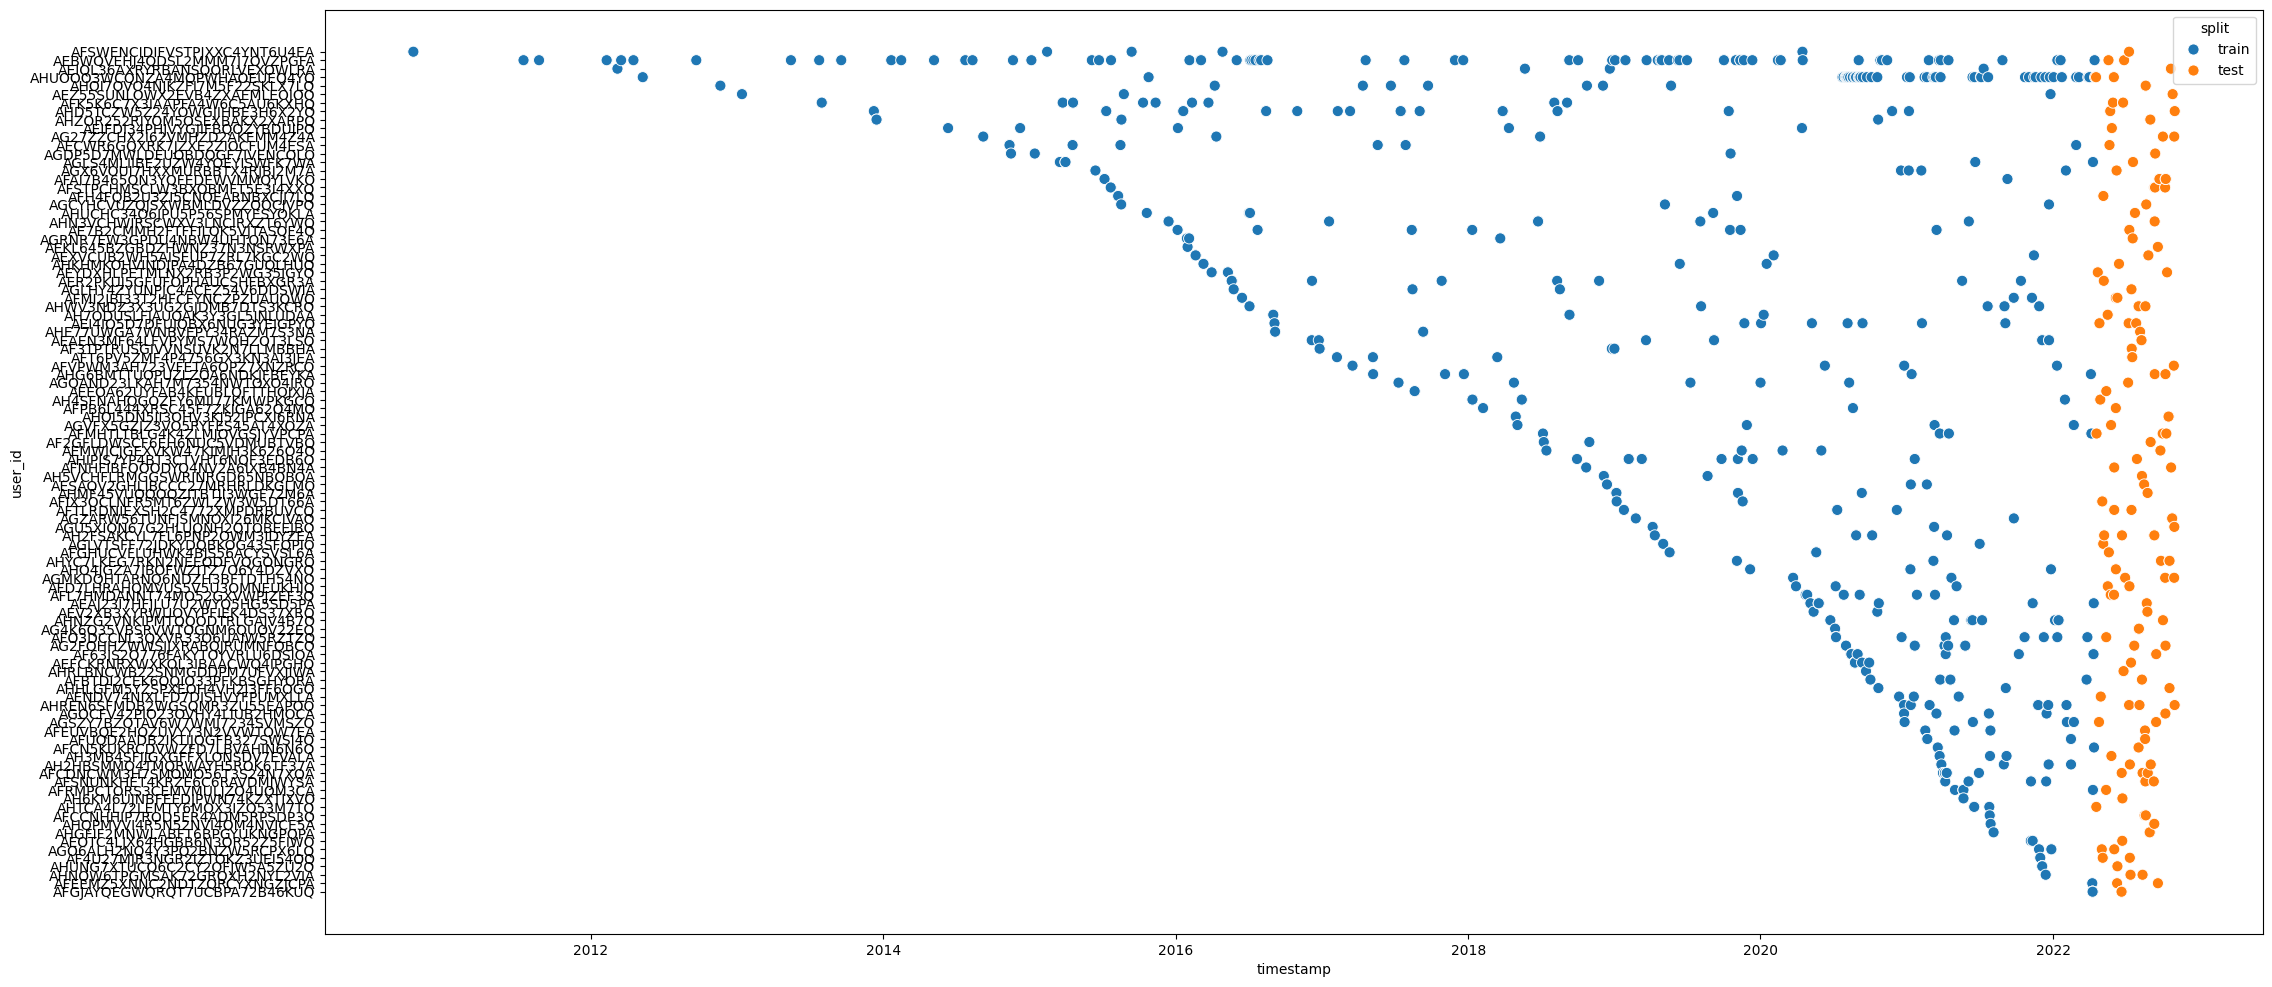

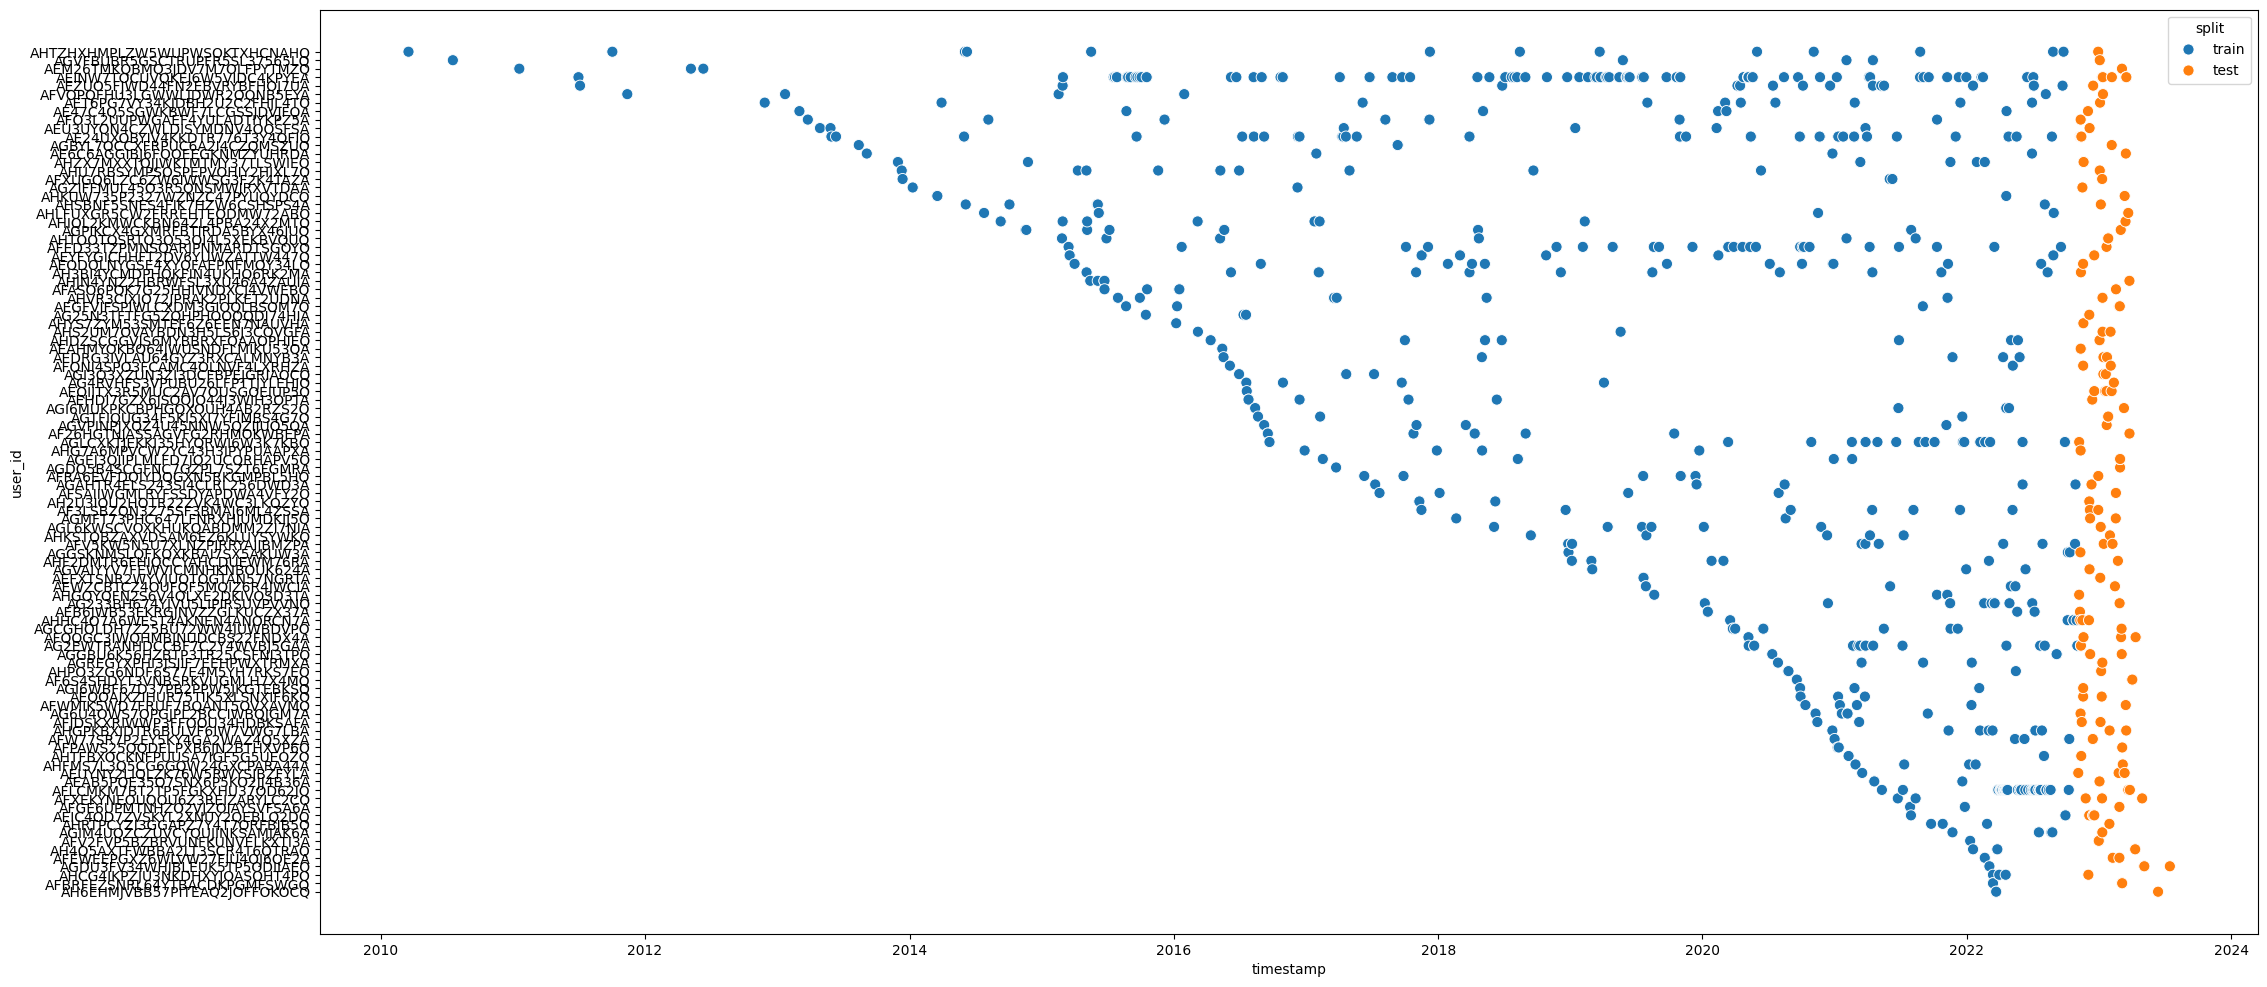

In [27]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)

In [28]:
splits['train'][splits['train'].user_id.isin(test_gt.user_id)]

,user_id,item_id,rating,timestamp
36124,AGWDYYVVWM3DC3CASUZKXK67G6IA,B000050FET,5.0,977274582000
36125,AGWDYYVVWM3DC3CASUZKXK67G6IA,B09JRQYJYW,5.0,1023918861000
36126,AGWDYYVVWM3DC3CASUZKXK67G6IA,B09FFKML75,5.0,1024290745000
36128,AGWDYYVVWM3DC3CASUZKXK67G6IA,B075KFVXJY,5.0,1029506122000
29410,AHMG3ALUBE3FEBHODTBHP5J24YDA,B000065DK4,5.0,1036701958000
...,...,...,...,...
612575,AFPERPRU55TMACTFCWF2EMGBEHEA,B08D43LHYP,5.0,1649998036792
100056,AFD4LMXMCFH6LF4NPVUUNLHEV5FQ,B0BZB49VDD,5.0,1649998243002
5215958,AGYOX4CVO7VXGEEQY52XL6KKEDAQ,B09JB734G3,5.0,1649998381183
3666384,AFQUQ6WBGTYCUPCPTQ4UGHJ7DW7Q,B00U2VQZDS,5.0,1649998893649


In [29]:
len(set(splits['train'].item_id))

152043

In [30]:
len(set(val_gt.item_id))

55264

In [31]:
len(set(test_gt.item_id)) 

43608

In [32]:
len(set(test_gt.item_id) - set(val_gt.item_id))

10745

In [33]:
splits['train'][splits['train'].item_id.isin(set(test_gt.item_id) - set(val_gt.item_id))]

,user_id,item_id,rating,timestamp
36126,AGWDYYVVWM3DC3CASUZKXK67G6IA,B09FFKML75,5.0,1024290745000
3222720,AEIL25EDGJJOZJ2ATD4XW4PBLRIA,B00005303E,5.0,1073274784000
2743070,AFQPX2VNHWSUTFXK7764KUCXGA7A,B00005JS5G,5.0,1088629054000
36142,AGWDYYVVWM3DC3CASUZKXK67G6IA,B00ZOZVBXQ,5.0,1095763980000
2793616,AGJMT25QZRUJZMQWLU7LMT6DEOHQ,B0000530LV,4.0,1096061300000
...,...,...,...,...
1693406,AFQIHQDYJE7MACANYK5TUL5GZUCQ,B00CGO4K04,5.0,1649995087465
1093745,AHNPBHSGYW32BGYTXME7M4YABVZQ,B0BYYSLMTQ,5.0,1649995615905
6260874,AGFFCGQTNV2DUYSKVMV3QMI7MJXQ,B09F8HMDSJ,4.0,1649997590811
6352029,AG6J26JTTZYKLPK2IIKBJPQRRZQA,B08CSKXZ79,5.0,1649997936384


In [34]:
len(set(val_gt.item_id) - set(test_gt.item_id))

22401

In [35]:
splits['train'][splits['train'].item_id.isin(set(val_gt.item_id) - set(test_gt.item_id))]

,user_id,item_id,rating,timestamp
36125,AGWDYYVVWM3DC3CASUZKXK67G6IA,B09JRQYJYW,5.0,1023918861000
36129,AGWDYYVVWM3DC3CASUZKXK67G6IA,B086WPXMYY,5.0,1041031826000
36130,AGWDYYVVWM3DC3CASUZKXK67G6IA,B000052Y33,5.0,1052649084000
3296151,AEK5KVD6AVN6INF3V2LGBV6MWULQ,B000050B6Z,5.0,1057776462000
3981636,AG5HHTEBKFEPR7PNAWBEV3BUJT2Q,B086WPXMYY,5.0,1068146486000
...,...,...,...,...
3604123,AHWLAJMDMMY3U64I5ISWYBVE3S7Q,B09SKRN9HS,5.0,1649997625638
5454125,AG57XB5NOQK2IQ4V7MX5T4FHH6YQ,B09STDQ6RX,5.0,1649997702509
455189,AGSVNZDZNPCMXG5DEFXMZNRH2LCQ,B0B3ST9C2T,4.0,1649997794406
4384025,AGCTQUUGYONW3L3CXT5KGGH7Z5SA,B09HCVR531,5.0,1649998736959


In [36]:
test_gt

,user_id,item_id,rating,timestamp
2866995,AEWQI3GELK2OOR376DBDMJCVCBKA,B0BYPM1RJC,4.0,1667453572249
6496820,AGYHKDZOOP4EOSO7RMX2EIQZ6BWA,B0B5GLSWQL,5.0,1667453582622
4549107,AH2XZBSDLT2QDYEFM5MQQPWDQDAA,B0BHTS5WH5,5.0,1667453918981
3034838,AHWFD4N24Q54HOOCL46DBC4TPD7Q,B07WXK722K,4.0,1667454321532
6383566,AHNKM5C47WQUIGSSPZCAMDCS4KXQ,B08N5Z924G,5.0,1667454349792
...,...,...,...,...
6623956,AEAICWQFNV7KCNTZTHPPKKBAX4MQ,B0C2PW3TN5,5.0,1693953393163
6623957,AEAICWQFNV7KCNTZTHPPKKBAX4MQ,B001U5B5HQ,5.0,1693953520517
6623958,AEAICWQFNV7KCNTZTHPPKKBAX4MQ,B09X9TRH99,5.0,1693953583514
6622998,AE3FYAYNJHKQRFH3GFGWTJRA5XKA,B0B5WBBMBZ,5.0,1693998764112


In [37]:
test_gt[test_gt.item_id.isin(val_gt.item_id.unique())]

,user_id,item_id,rating,timestamp
2866995,AEWQI3GELK2OOR376DBDMJCVCBKA,B0BYPM1RJC,4.0,1667453572249
4549107,AH2XZBSDLT2QDYEFM5MQQPWDQDAA,B0BHTS5WH5,5.0,1667453918981
3034838,AHWFD4N24Q54HOOCL46DBC4TPD7Q,B07WXK722K,4.0,1667454321532
6383566,AHNKM5C47WQUIGSSPZCAMDCS4KXQ,B08N5Z924G,5.0,1667454349792
896935,AFH4WEXTADNDE7M553AME474N5JA,B09KC5KL87,5.0,1667455003037
...,...,...,...,...
6623956,AEAICWQFNV7KCNTZTHPPKKBAX4MQ,B0C2PW3TN5,5.0,1693953393163
6623957,AEAICWQFNV7KCNTZTHPPKKBAX4MQ,B001U5B5HQ,5.0,1693953520517
6623958,AEAICWQFNV7KCNTZTHPPKKBAX4MQ,B09X9TRH99,5.0,1693953583514
6622998,AE3FYAYNJHKQRFH3GFGWTJRA5XKA,B0B5WBBMBZ,5.0,1693998764112
